<a href="https://colab.research.google.com/github/juno-yuu/MFE-DAML/blob/main/Problem_Set_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Set 4

### Question 1: Automatic Stock Picking Algorithm


a. Download the data. The firm-level characteristics you will use are lnIssue, lnProf,
lnInv, and lnME. For each of these four characteristics, create new, additional
characteristics as the squared value of the original characteristic. Name the new
characteristics the same as the original, but with a "2" at the end. For instance, for
lnProf, the squared value should be lnProf2. Further, create additional characteristics
by multiplying each characteristic with lnME (except for lnME itself, which you already
have squared). To name these, add _ME at the end. Thus, lnProf interacted with lnME is
named lnProf_ME. You should have now gone from 4 to 11 characteristics.

In [2]:
import os
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics # make sure scikit-learn is installed
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
import warnings
warnings.filterwarnings(action='once')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
#load data
data_raw = pd.read_csv("/content/drive/MyDrive/MFE 431 DAML /StockRetAcct_DT.csv")

data = data_raw[['FirmID','year','lnIssue','lnProf','lnInv','lnME']]


In [4]:
# creat new,  additional characteristics as the squared value of the original characteristic.
data= pd.concat([data,data.iloc[:,2:6].apply(np.square, axis=1).add_suffix('2')],axis=1)
# create additional characteristics by multiplying each characteristic with lnME
data = pd.concat([data,data.iloc[:,2:5].multiply(data["lnME"], axis="index").add_suffix('_ME')],axis=1) #11 variables included
data= data.dropna()
data.head()

,FirmID,year,lnIssue,lnProf,lnInv,lnME,lnIssue2,lnProf2,lnInv2,lnME2,lnIssue_ME,lnProf_ME,lnInv_ME
0,6,1980,0.031344,0.201767,0.093626,12.581472,0.000982,0.040710,0.008766,158.293448,0.394356,2.538527,1.177954
1,6,1981,0.044213,0.215661,0.087242,12.907996,0.001955,0.046510,0.007611,166.616365,0.570708,2.783750,1.126121
2,6,1982,-0.068195,0.184087,0.111663,12.557775,0.004651,0.033888,0.012469,157.697701,-0.856377,2.311729,1.402244
3,6,1983,-0.071780,0.165531,-0.033117,12.561954,0.005152,0.027401,0.001097,157.802677,-0.901693,2.079396,-0.416017
4,10,1991,0.115204,0.239788,0.300051,11.565831,0.013272,0.057498,0.090031,133.768451,1.332431,2.773345,3.470341


(i) For each year in the sample, cross-sectionally demean each of the 11 characteristics.
That is, for each characteristic and each year subtract the average value of that
characteristic across stocks. Then add as final characteristic a column of 1's to the
dataset. This effectively inserts an intercept in the relation between the MVE portfolio
weight and the characteristics.


In [5]:
df_demean=data.copy()
def demeaned(arr):
  return arr- arr.mean()

df_demean = df_demean.groupby('year').transform(demeaned)
df_demean[['c']] = 1
df_demean[['year']] = data[['year']]
#df_demean = df_demean.set_index('year') #inserts an intercept in the relation between the MVE portfolio weight and the characteristics
#For matrix multiplication, we drop the last row of the dataframe

Next calculate the factor portfolio returns corresponding to each of these 12
characteristics, as explained on slide 48 in the Topic 4 note (F is implicitly defined in
the equation there). Note that the factor corresponding to the constant is simply an
equal-weighted portfolio of all stocks (the "market"). The overall idea is that with this
approach you have a market factor and long-short characteristics factors.



*   Here by slides 48, $F$ is defined as $F_{t+1} = \sum^{N_t}_{i=1}X_{i,t}R^e_{i,t+1}$, where $X_{i,t}$ is 11 characteristcis in this case, $R^e_{i,t+1}$ is the next priod return









In [6]:
# create next period excess returns
df_demean['ExRet'] = np.exp(data_raw.lnAnnRet)-np.exp(data_raw.lnRf)

In [7]:
# get sample mean
def dot(col):
    return col.T@col.ExRet

Factor_Return = df_demean.iloc[:,1:].groupby('year').apply(dot)
Factor_Return = Factor_Return.drop(['year'], axis = 1).iloc[:,0:12]
# get variance-covariance matrix
col_name = ('lnIssue','lnProf', 'lnInv', 'lnME',
       'lnIssue2','lnProf2','lnInv2','lnME2','lnIssue_ME','lnProf_ME','lnInv_ME', 'C',)
cov = pd.DataFrame(np.cov(Factor_Return.T))
cov.columns=col_name
cov.index=col_name
# get sharpe ratio
sharpe_ratio = pd.DataFrame((Factor_Return.mean(axis=0))/(np.sqrt(np.diag(cov))))
sharpe_ratio.columns = ['Sharpe Ratio']

In [8]:
cov

,lnIssue,lnProf,lnInv,lnME,lnIssue2,lnProf2,lnInv2,lnME2,lnIssue_ME,lnProf_ME,lnInv_ME,C
lnIssue,484.247627,-723.995935,479.372073,371.861285,269.099214,991.403035,725.136400,1.140169e+04,6769.406854,-9750.236593,7128.603667,1497.966308
lnProf,-723.995935,1502.070512,-660.189133,-1398.098805,-350.328973,-2143.373967,-1076.862146,-4.193521e+04,-10227.585057,20022.133906,-10181.853016,-13.422415
lnInv,479.372073,-660.189133,696.573701,564.566730,278.599125,847.547110,1006.271201,1.733066e+04,6748.121943,-8870.453907,10144.641237,1476.757452
lnME,371.861285,-1398.098805,564.566730,7744.138324,156.802587,2170.171371,1036.013349,2.213437e+05,6233.656933,-17245.349227,10090.637268,-7231.443892
lnIssue2,269.099214,-350.328973,278.599125,156.802587,205.944691,493.483351,435.031680,5.069551e+03,3744.292151,-4707.365274,4107.135716,1076.968783
lnProf2,991.403035,-2143.373967,847.547110,2170.171371,493.483351,3219.290859,1393.813398,6.523511e+04,14010.534553,-28515.993295,13205.162126,-100.660677
lnInv2,725.136400,-1076.862146,1006.271201,1036.013349,435.031680,1393.813398,1525.807832,3.147170e+04,10257.780966,-14435.044332,14806.442053,2223.695962
lnME2,11401.693501,-41935.208286,17330.657306,221343.687261,5069.550922,65235.107724,31471.703066,6.352930e+06,188974.433171,-519988.886182,306205.313143,-191649.847340
lnIssue_ME,6769.406854,-10227.585057,6748.121943,6233.656933,3744.292151,14010.534553,10257.780966,1.889744e+05,94887.113693,-137586.627716,100686.054500,19988.314465
lnProf_ME,-9750.236593,20022.133906,-8870.453907,-17245.349227,-4707.365274,-28515.993295,-14435.044332,-5.199889e+05,-137586.627716,267319.124203,-136506.098213,-2712.426978


(ii) Next, you are to use the Elastic Net procedure (with alpha (l1_ratio) =0.5) to estimate
the b coefficients. We will use the 25 year sample from 1980-2004 for the crossvalidation
exercise, and then we will use the 2005-2014 period for the out of sample
testing. The sklearn procedure ElasticNet is useful here, but note that you have to code
up the cross-validation yourself as the process we need to follow does not correspond
to that coded up in ElasticNetCV

First, find sample average factor returns and covariance matrix from
1980-1999.


In [9]:
# First subset the data 
# 1980-2004
Factor_insample = Factor_Return[0:25]
Factor_outsample = Factor_Return[25:]

In [10]:
Factor_outsample

,lnIssue,lnProf,lnInv,lnME,lnIssue2,lnProf2,lnInv2,lnME2,lnIssue_ME,lnProf_ME,lnInv_ME,c
year,,,,,,,,,,,,
2005,5.403550,-2.861234,1.708085,-41.959234,-1.422053,-2.234435,-1.794967,-1276.310760,75.806231,-52.737596,17.075068,174.051859
2006,1.065737,8.155112,-4.654037,30.883260,1.875986,-0.493804,-1.387720,917.235500,19.074520,125.966341,-59.573930,216.732893
2007,4.773745,1.710196,10.936219,27.226499,-4.487414,-1.382284,7.228035,804.362341,66.023493,35.057233,164.519983,-276.838506
2008,-15.464643,-0.101803,-5.093357,-62.637990,-9.028331,7.351371,-6.024950,-1851.107589,-229.655133,-4.709369,-85.676952,-444.684432
2009,0.374578,19.581095,-13.822912,-54.798470,1.010859,-27.654778,-4.455894,-1677.502640,-1.699760,238.630013,-203.434141,427.442543
2010,-7.530569,5.394919,-9.812465,-26.808727,-7.807869,3.291916,-1.474337,-912.792836,-110.678127,72.380370,-132.181752,658.424530
2011,-7.263162,-4.892317,-1.622873,25.059469,-2.924255,2.446160,-0.145948,833.604157,-116.161621,-56.977095,-27.132711,-31.666686
2012,2.942764,-3.639943,-4.412319,-17.032645,2.427037,2.597757,-0.524024,-533.038245,35.795494,-54.423026,-63.360507,432.747329
2013,1.631391,2.286579,-2.027161,15.910035,1.369023,7.275314,-1.685727,442.138990,23.019043,34.974434,-23.465789,416.360318


In [26]:
alphas = (10 ** np.linspace(10, -10, 500) * 0.002)
y25sample = Factor_Return[0:25]
fold1 = y25sample.drop(labels=range(2000,2005)) # 1980-1999
fold2 = y25sample.drop(labels=range(1995,2000)) # 1980-1994 & 2000-2004
fold3 = y25sample.drop(labels=range(1990,1955)) # 1980-1989 & 1995-2004
fold4 = y25sample.drop(labels=range(1985,1990)) # 1980-1984 & 1990-2004
fold5 = y25sample.drop(labels=range(1980,1985)) # 1985 - 2004
test1 = y25sample[20:25]
test2 = y25sample[15:20]
test3 = y25sample[10:15]
test4 = y25sample[5:10]
test5 = y25sample[0:5]
mse = [0] * 500
for i in range(0, 500):
  model = ElasticNet(alpha=alphas[i], fit_intercept=False, max_iter=1000000)
  coef1 = model.fit(fold1.cov(), fold1.mean()).coef_
  mse1 = np.mean((np.dot(test1.cov(), coef1) - test1.mean()) ** 2)
  coef2 = model.fit(fold2.cov(), fold2.mean()).coef_
  mse2 = np.mean((np.dot(test2.cov(), coef2) - test2.mean()) ** 2)
  coef3 = model.fit(fold3.cov(), fold3.mean()).coef_
  mse3 = np.mean((np.dot(test3.cov(), coef3) - test3.mean()) ** 2)
  coef4 = model.fit(fold4.cov(), fold4.mean()).coef_
  mse4 = np.mean((np.dot(test4.cov(), coef4) - test4.mean()) ** 2)
  coef5 = model.fit(fold5.cov(), fold5.mean()).coef_
  mse5 = np.mean((np.dot(test5.cov(), coef5) - test5.mean()) ** 2)
  mse[i] = np.mean([mse1, mse2, mse3, mse4, mse5])




The minimum MSE is 96844.382049 at alpha= 286643.845101


In [29]:
# output results
ind = mse.index(min(mse))
best_alpha = alphas[ind]
print("The minimum MSE achieved is {0:2f} at alpha equals to {01:2f}".format(min(mse),best_alpha))

The minimum MSE achieved is 96844.382049 at alpha equals to 286643.845101


iii) With the final b-vector in hand, calculate the out-of-sample average return, standard
deviation, and Sharpe ratio for the corresponding estimated "ex ante" MVE portfolio
with return b'F_t in the period 2005-2014.

In [22]:
# using best alpha found in the last question do outsample prediction and test
model = ElasticNet(alpha=alphas[mse.index(min(mse))], fit_intercept=False,max_iter=1000000)
coef_opt = model.fit(y25sample.cov(), y25sample.mean()).coef_

pred = np.dot(Factor_outsample,coef_opt)
mean_outsample = pred.mean()
std_outsample = pred.std()
sharpe_ratio_outsample = mean_outsample/std_outsample
print("Out of Sample Return mean is {:2f}".format(mean_outsample))
print("Out of Sample Return standard deviation is {:2f}".format(std_outsample))
print("Out of Sample Return sharpe ratio {:2f}".format(sharpe_ratio_outsample))

Out of Sample Return mean is 0.422159
Out of Sample Return standard deviation is 0.938750
Out of Sample Return sharpe ratio 0.449703


iv) Plot the cumulative return on this portfolio relative to that on the market (get market
return using the value-weights in the sample, MEwt) over the 2005-2014 period,
where you normalize the "MVE" portfolio's standard deviation to be the same as the
market over this period. Compare. Note that one should really redo the estimation
each year to get proper out of sample results that would mimic what you would do in
the real world. Also, you could experiment in the in-sample cross-validation with
different values for lambda to see what works best.

In [24]:
df_compare = data_raw.loc[data_raw['year']>=2005]
df_compare = df_compare.loc[df_compare['year']<=2015]
df_compare['ExRet'] = np.exp(data_raw.lnAnnRet)-np.exp(data_raw.lnRf)
df_compare = df_compare[['year','ExRet','MEwt']]
def dot(col):
    return col.T@col.ExRet

mkt_rtn = df_compare.groupby('year').apply(dot)[['MEwt']]
mkt_rtn.columns = ['Market Return']
#normalize return
normal_vector = mkt_rtn.std()/std_outsample
model_return_norm = pred*normal_vector['Market Return']
model_return = pd.DataFrame(model_return_norm,index = range(2005,2015))
model_return.columns = ['Model Return']
df_plot = model_return.join(mkt_rtn)
df_plot['Market Culmulative Return'] = np.cumprod(1 + mkt_rtn)-1
df_plot['Model Culmulative Return'] = np.cumprod(1 + model_return)-1

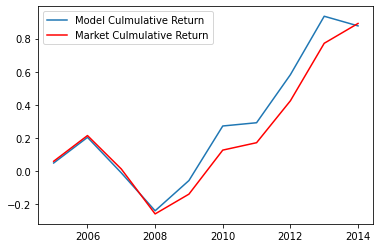

In [25]:
ax = plt.gca()

df_plot.plot(kind='line',y='Model Culmulative Return',ax=ax)
df_plot.plot(kind='line',y='Market Culmulative Return', color='red', ax=ax)

plt.show()